# Conditional GAN for Battery Temperature Generation
This notebook demonstrates a Conditional GAN (cGAN) that generates battery temperature sequences conditioned on SoC, cycle number, and ambient temperature.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# Simulate data with conditions: SoC, cycle number, ambient temperature
np.random.seed(0)
n_samples = 500
seq_len = 50
conditions = np.random.rand(n_samples, 3)  # SoC, Cycle, Temp
sequences = np.array([
    np.sin(np.linspace(0, 2 * np.pi, seq_len)) + np.random.normal(0, 0.1, seq_len) + 0.05 * soc
    for soc in conditions[:, 0]
])

scaler_seq = MinMaxScaler()
scaler_cond = MinMaxScaler()
X_seq = torch.tensor(scaler_seq.fit_transform(sequences), dtype=torch.float32)
X_cond = torch.tensor(scaler_cond.fit_transform(conditions), dtype=torch.float32)

In [3]:
# Dataset and Loader
class ConditionalBatteryDataset(Dataset):
    def __init__(self, seq, cond):
        self.seq = seq
        self.cond = cond
    def __len__(self): return len(self.seq)
    def __getitem__(self, idx): return self.cond[idx], self.seq[idx]

data = ConditionalBatteryDataset(X_seq, X_cond)
dataloader = DataLoader(data, batch_size=32, shuffle=True)

In [4]:
# Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, cond_dim, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(cond_dim + noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )
    def forward(self, z, cond):
        return self.model(torch.cat([z, cond], dim=1))

class Discriminator(nn.Module):
    def __init__(self, cond_dim, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(cond_dim + input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x, cond):
        return self.model(torch.cat([x, cond], dim=1))

In [5]:
# Training loop
G = Generator(3, 10, seq_len)
D = Discriminator(3, seq_len)
loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.001)
opt_D = optim.Adam(D.parameters(), lr=0.001)

G_losses, D_losses = [], []
for epoch in range(10):
    for cond, real_seq in dataloader:
        batch = cond.size(0)
        z = torch.randn(batch, 10)
        real_labels = torch.ones((batch, 1))
        fake_labels = torch.zeros((batch, 1))

        # Discriminator
        fake_seq = G(z, cond).detach()
        d_loss = (loss_fn(D(real_seq, cond), real_labels) + loss_fn(D(fake_seq, cond), fake_labels)) / 2
        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # Generator
        z = torch.randn(batch, 10)
        fake_seq = G(z, cond)
        g_loss = loss_fn(D(fake_seq, cond), real_labels)
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

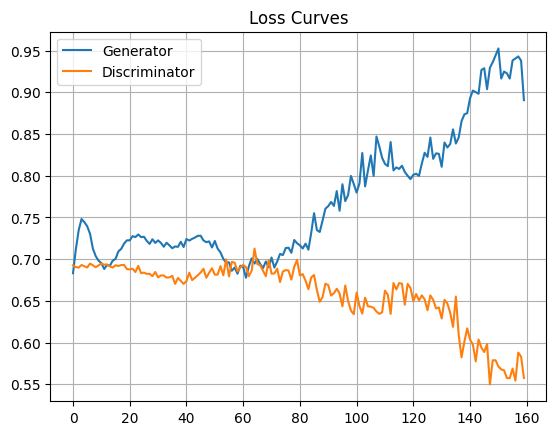

In [6]:
# Plot losses
plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator')
plt.legend()
plt.title('Loss Curves')
plt.grid(True)
plt.show()

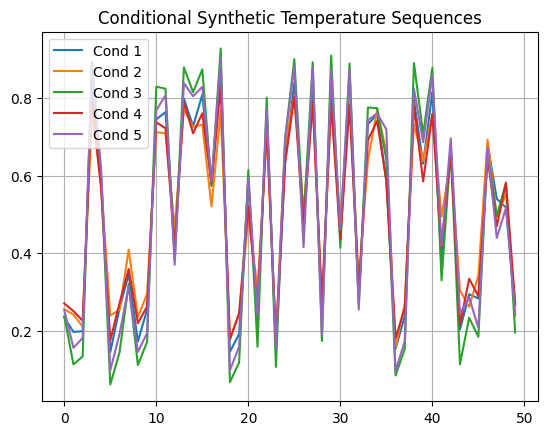

In [8]:
# Generate conditional samples
z = torch.randn(5, 10)
test_cond = X_cond[:5]
fake_outputs = G(z, test_cond).detach().numpy()

for i, f in enumerate(fake_outputs):
    plt.plot(f, label=f'Cond {i+1}')
plt.title('Conditional Synthetic Temperature Sequences')
plt.legend()
plt.grid(True)
plt.show()